<!--TABLE OF CONTENTS-->
# Table of Contents:
- [Intro to GANs](#Intro-to-GANs)
- [Create DataLoader, Resize and Normalize Images](#Create-DataLoader,-Resize-and-Normalize-Images)
- [How GAN training works](#How-GAN-training-works)
- [The DCGAN Architecture](#The-DCGAN-Architecture)
- [Build the GAN](#Build-the-GAN)
  - [Some extra GAN tricks: Instance Noise, Spectral Norm, SELU, Dropout](#Some-extra-GAN-tricks:-Gaussian-Instance-Noise,-Spectral-Norm,-Other-Normalization-Techniques)
  - [Build Generator](#Build-Generator)
  - [Build Discriminator](#Build-Discriminator)
  - [Check Model Architecture](#Check-Model-Architecture)
  - [Define optimizers for both networks](#Define-optimizers-for-both-networks)
  - [Training Utilities](#Training-Utilities)
- [Build Training Loop](#Build-Training-Loop)
  - [Track Progress with TensorBoard](#Track-Progress-with-TensorBoard)
  - [Make training config and train model](#make-training-config-and-train-model)
  - [Load Pre-Trained Checkpoints](#Load-Pre-Trained-Checkpoints)
- [Test Model: Generate Images](#Test-Model:-Generate-Images)
  - [Image Gen Utilities](#Image-Gen-Utilities)
  - [Generated Images and Checkpoint Progression](#Generated-Images-and-Checkpoint-Progression)
    - [5 Epochs](#5-Epochs)
    - [10 Epochs](#10-Epochs)
    - [25 Epochs](#25-Epochs)
    - [50 Epochs](#50-Epochs)
    - [57 Epochs](#57-Epochs)
- [Lessons Learned: How to Stabilize and Optimize a GAN](#Lessons-Learned:-How-to-Stabilize-and-Optimize-a-GAN)
- [References](#References)

# Intro to GANs

In this notebook I'm going to give a brief intro to Generative Adversial Networks (GANs) and an in-depth analysis of Deep Convolutional GANs (DCGANs) and their tuning.

[GANs were first introduced by Goodfellow et al in 2014.](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

We can imagine any training data to lie in an n-dimensional space - for example, 28x28 images from MNIST
can be sampled from an 784-dimensional space, where n == 28*28 == 784 - each of 784 points for each image has a probability
associated with all its possible values (e.g. in range [0,255] for MNIST) - hence MNIST images can be represented by a distribution. 
The idea is simple: Two networks act as adversaries - the generator (G) has the objective to fool the discriminator (D), while D has the objective to not be fooled.
G samples data from a random distribution. D is fed either samples from G or samples from real training data and attempts to classify 
G's output as having come from real training data distribution or not. 
G is penalized by outputs which D accurately classifies as fakes; it thus learns to generate data as close
as possible to the real training data distribution. 

For game theory enthusiasts, the generator-discriminator network pair are playing a minimax game (LINK) against each other;
their objective function is the predictability of G's output. G tries to minimize predictability while D tries to maximize it.

D is penalized by incorrectly classifying G's output as real training data; it thus learns to identify fake 
data and so increases the likelihood that G will be penalized; D's role is to provide feedback to and facilitate G's learning. 

**Ultimately, this means that each of the networks will learn the best possible strategy to take - the best way to fake training data for G
and the best way to discriminate between real and fake data for D. It is at this point that loss converges - reaches a Nash equillibrium - for both networks at a saddle point.**
According to Goodfellow et al, this network pair will reach this best strategy - the solution - when G recovers the training data as
truthfully as possible and D can't distinguish between fake and real data, being 50% sure that anything G makes is real - and at this point neither G nor D can do their task any better.

Once G can generate such data, it will theoretically be able to create new samples from a low-dimension (e.g. 100) random Gaussian latent vector that will closely resemble the training data - be it handwritten digits or human faces. As long as we've tuned our network properly.

Both networks can be trained by backpropogation; common implementations of generator-discriminator network pairs are 
multilayer perceptrons and CNNs. In this notebook, we'll implement the CNN-based GAN: the DCGAN



In [ ]:
import os
import re
import time
import enum

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.utils
from torch import nn
from torch.optim import Adam, SGD
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# need to import files from google drive into colab 
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


~We'll try applying the GAN paradigm on the MNIST dataset, our objective being to generate real handwritten digits.~ 
Just kidding. [MNIST is no good for computer vision](https://twitter.com/fchollet/status/852594987527045120): Ian Goodfellow, The author of GANs, and Francois Chollet, Keras author, give a few details in the above link to their twitter conversation: the gist is that **when you use MNIST, often good CV optimizations don't work, and bad ones do. So MNIST is a poor representation of CV tasks.**

Instead, we're going to use CelebA: Celebrity Face Attributes by [Liu et al, 2015](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

In [ ]:
# copy CelebA dataset from (my) gdrive and unzip
!cp '/content/drive/My Drive/DL/DCGAN/CelebA.zip' .
!unzip -q datasets1.zip 
print('CelebA dataset loaded from gdrive')

CelebA dataset loaded from gdrive


# Create DataLoader, Resize and Normalize Images

In [ ]:
# images are often represented by pixel brightness values in a range [0,255] 
# Normalizing pixel values to the [-1,1] range helps train GANs: see https://github.com/soumith/ganhacks
# make a PyTorch function which moves PIL images to a tensor and normalizes them to [-1,1]:
normalize = transforms.Compose([
        transforms.Resize(size=(157,128)),
        transforms.ToTensor(),
        
        transforms.Normalize((0.5,), (0.5,))  
    ])

# CelebA (Celebrity Face Attributes), included with PyTorch
# the images will be converted from np.array to tensor and normalized
# if you try to download fom PyTorch you may encounter an error 
# in that case download from official (Liu et al) baidu drive: https://pan.baidu.com/s/1CRxxhoQ97A5qbsKO7iaAJg
# password "rp0s" for baidu drive
# torch tries to download from (Liu et al) gdrive which has a limit on how many downloads it can provide 
# but try it out; you might get lucky. Otherwise, this function just loads from root
dataset = datasets.CelebA(root='./datasets/CelebA', split='train', download=True, transform=normalize)

# choose a batch size - 128 used in original DCGAN by Radford et al, but lower is better - more on this later
batch_size = 64

# create a PyTorch DataLoader object which returns CelebA images in shuffled batches of 128,
# discarding the last batch of <128 images
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# check dataset size
print(f'CelebA: {len(dataset)} celebrity face training images.')

# generate a batch of images from our dataloader
batch = next(iter(dataloader))  
# check our batch dimensions
print(f'Number of tensors in batch: {len(batch)}')

Files already downloaded and verified
CelebA: 162770 celebrity face training images.
Number of tensors in batch: 2


We get ~160k images in the CelebA training set and our dataloader returns two tensors per batch .According to [Liu et al, 2015](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), images each have 40 boolean/one-hot labels representing various visual attributes such as:
 - wearing a hat
 - pointy nose
 - wavy hair
 - sunglasses
and so forth. 

Let's check what data our batch contains: 

In [134]:
print(batch[0].size())
print(batch[1].size())

torch.Size([64, 3, 157, 128])
torch.Size([64, 40])


Clearly, batch[0] refers to 128 RGB 128x128 images in (N,C,H,W) tensor format. batch[1] clearly contains their 40 labels:

In [ ]:
# images in (C,H,W) format
print(f'Images are size {batch[0].size()[1:]}')

# check that we've normalized to [-1,1] correctly by inspecting pixel brightness dimensions
# batch[0] --> (N,C,H,W); batch[0][0] --> (C,H,W); batch[0][0][0] --> (H,W) ---> image pixel values
print(f'{batch[0][0][0].numel()} pixels in each image')
print(f'Pixel values are in range [{torch.min((batch[0][0][0]))}, {torch.max((batch[0][0][0]))}]')

# second dimension of batch should be 40 one-hot integer labels
print(f'CelebA attribute labels:{batch[1][0]}')

Images are size torch.Size([3, 157, 128])
20096 pixels in each image
Pixel values are in range [-1.0, 1.0]
CelebA attribute labels:tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0])


Looks good so far - integer labels for RGB 218x178 images with pixels normalized to [-1,1].

The labels are indeed boolean/one-hot encoded.  Let's look at the images:

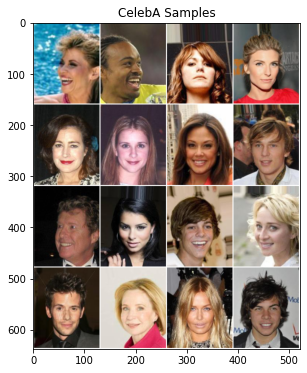

In [ ]:
# get the images from the batch
img = batch[0]

# we'll visualize a 4x4 grid of images
img_grid_size = 4
img_grid = img[:img_grid_size**2] 

# make a grid of images from the tensor; normalize to [0,1] so all pixels are visible
# make_grid pads images with 2 black pixels by default; set pad_value==white (1) so we can see a grid
grid = torchvision.utils.make_grid(tensor=img_grid,nrow=4, normalize=True,pad_value=1)

# swap H,W dimensions for matplotlib's imshow() to work properly
grid = np.moveaxis(grid.numpy(), 0, 2) 

# plot images 
plt.figure(figsize=(6, 6))
plt.title("CelebA Samples")
# imshow plots axes with # of pixels by defaul|t - 4*28 images + 4*2 padding == 120 pixels. 
plt.imshow(grid)
plt.show()

Those are faces alright, presumably of celebrities. Make a dictionary to hold the attributes so we can play with the trained DCGAN later on. Attributes from Liu et al's baidu drive 'list_attr_celeba.txt'.

**This will mostly be useful to figure out which feature is which using linear interpolation once our generator is trained; for labelling samples we would use an Auxilliary GAN (AC-GAN) where we embed image labels into an extra tensor dimension.**

In [ ]:
attributes_dict = {
    '5_o_Clock_Shadow': torch.bool,
    'Arched_Eyebrows': torch.bool,
    'Attractive': torch.bool,
    'Bags_Under_Eyes': torch.bool,
    'Bald': torch.bool,
    'Bangs': torch.bool,
    'Big_Lips': torch.bool,
    'Big_Nose': torch.bool,
    'Black_Hair': torch.bool,
    'Blond_Hair': torch.bool,
    'Blurry': torch.bool,
    'Brown_Hair': torch.bool,
    'Bushy_Eyebrows': torch.bool,
    'Chubby': torch.bool,
    'Double_Chin': torch.bool,
    'Eyeglasses': torch.bool,
    'Goatee': torch.bool,
    'Gray_Hair': torch.bool,
    'Heavy_Makeup': torch.bool,
    'High_Cheekbones': torch.bool,
    'Male': torch.bool,
    'Mouth_Slightly_Open': torch.bool,
    'Mustache': torch.bool,
    'Narrow_Eyes': torch.bool,
    'No_Beard': torch.bool,
    'Oval_Face': torch.bool,
    'Pale_Skin': torch.bool,
    'Pointy_Nose': torch.bool,
    'Receding_Hairline': torch.bool,
    'Rosy_Cheeks': torch.bool,
    'Sideburns': torch.bool,
    'Smiling': torch.bool,
    'Straight_Hair': torch.bool,
    'Wavy_Hair': torch.bool,
    'Wearing_Earrings': torch.bool,
    'Wearing_Hat': torch.bool,
    'Wearing_Lipstick': torch.bool,
    'Wearing_Necklace': torch.bool,
    'Wearing_Necktie': torch.bool,
    'Young': torch.bool,
    }

And the dataset is ready to use.

# How GAN training works
A more practical look at the training of GANs:
Common implementations of generator-discriminator network pairs use
multilayer perceptrons and CNNs.
Both networks of a GAN can be trained by backpropogation of the error from the following loss function:
In Goodfellow's paper, adversarial loss is described as 

**_log D(x) + log(1 – D(G(z)))_**

- _x_ is an image in (C,H,W) format. 
- _z_ is a vector constructed by sampling from  a latent space learned by the generator
- _D(x)_ is the discriminator function which outputs the probability that _x_ comes from the distribution of the real training data. The function _D_ is simply a binary classifier - real data, or fake data.
- _G(z)_ is the generator function, transforms the latent space vector _z_ to the same space as the training data (i.e. 3x32x32 for MNIST)
- _p<sub>data</sub>_ is the probability distribution of the real training data
- _p<sub>z</sub>_ is the probability distribution of the fake training data output by _G(z)_
- _D(G(z))_ is the probability that G(z) is classfied same as real data, G(x)
- D learns to output lim_D(x)_ -> 1, and lim_D(G(z))_ -> 0
- D's objective is to maximize log(D(x)) - log probability of classifying real data as real data
- G's objective is to minimize log(1-D(G(z))) - log inverted probability of classifying fake data as real data (i.e. prob of classifying fake data as fake data

We use log probability so probabilities are additive (otherwise the product of probabilities would always approach 0). 
The GAN's loss function is then just binary cross-entropy over outputs from two batches of data; real and fake.
In Goodfellow et al, the authors say that log(1-D(G(z)) saturates when G is poorly trained and D is well trained.
According to [Arjovsky and Bottou, 2017](arxiv.org/pdf/1701.04862.pdf), if the discriminator is too good, then its loss gradients will vanish and so the generator will not learn: An optimized disciminator precludes the generator from making progress.

**As such, in practice G is trained by maximizing log(D(G(z))** which provides higher gradients, faster training, and a lesser likelihood of a vanishing gradient. In sum: Instead of training the GAN to minimize D being correct, we train the GAN to maximize that D is incorrect.

And that's it - that's the meat of the GAN, the adversarial loss function: just a doubled application of binary cross entropy.

**Update Discriminator:**

- Forward real images minibatch through the Discriminator;

- Compute Discriminator loss and calculate gradients for the backward pass;

- Generate fake images minibatch via forward pass of latent vector z to Generator

- Forward generated fake minibatch (G(z)) through the Discriminator;

- Compute the Discriminator loss and compute gradients for the backward pass;

- Add: real minibatch gradients + fake minibatch gradients

- Update Discriminator using Adam or SGD.

**Update Generator:**

- **Log Trick:** Flip the target labels: fake images from the generator G(z) get labeled as real. This step configures binary cross-entropy to maximize log(D(G(z))) for the Discriminator loss passed to the Generator and helps overcome the problem of Generator's vanishing gradients. This is the log trick where instead of minizming log(1 - D(G(z))) we instead maximize log(D(G(z))).

- Forward fake images minibatch through the updated Discriminator: D(G(z)), where z is labeled as real images for the log trick;

- Compute Generator loss based on the updated Discriminator output;

- Update the Generator using Adam (SGD results in a too-slow generator that is outpaced by the Discriminator, whose loss goes to 0 signalling a failure mode)


In the above, we specifically train the discriminator first; this is not by chance. This is because if the generator produces an image that looks entirely real to the discriminator, the generator will just get stuck producing that image. This is called [mode collapse](https://developers.google.com/machine-learning/gan/problems). **Training the discriminator first is one way to avoid mode collapse.**

Another way to avoid mode collapse is by using [Wasserstein loss, as first described by Arjovsky et al, 2017](https://arxiv.org/abs/1701.07875) instead of adversarial loss as described by Radford et al. Wasserstein loss measures the distance between two probability distributions (similar to KL divergence, used in sparse autoencoders to ensure training weights are close to 0 in each hidden layer of a network). Roughly speaking, Wasserstein loss computes the quantity (percentage) of the difference between probability distributions, and the distance between the portion of the probability disributions which are different. [Earth mover's distance](https://en.wikipedia.org/wiki/Earth_mover%27s_distance) is another name for Wasserstein loss, and here's why: We imagine two different probability disributions as two differently-shaped dirt piles: the Wasserstein distance (loss) is then the product of the amount of dirt moved and the distance over which it is moved so that the two piles take on the exacft same shape. Wasserstein distance quantifies the minimum energy cost in transforming one probability distribution into the shape of another. **Wasserstein loss ultimately penalizes the generator w.r.t. the distance between the probability distributions of generated training images _P<sub>z</sub>_ and real training images _P<sub>data</sub>_**



# The DCGAN Architecture
It is identical to the original GAN architecture, but uses CNNs for both G and D (instead of dense MLPs).
 
We should first understand transpose conv 2d: 
Conv transpse is sort of like the opposite of maxpool; conv transpose layers upsample (increase dimensionality) of their inputs.
However, conv transpose is unlike maxpool in that they use kernels just like regular 2d conv.
Just as in regular 2d conv, transpose filters have weights; we take the product of _each_ (single) value in the input volume
with each (of many) weights of the filter. 

Radford et al build their discriminator CNN with standard convolutional layers/filters, batch norm, and LeakyyReLU as activation (ReLU that doesn't quite saturate below 0)
the generator CNN uses conv-tranpose filters, batchnorm, and regular ReLU.
The input to the generator is a latent space vector _z_ sampled from a standard normal distribtuion. 
Its output is an image in standard (C,H,W) format. The conv2dtranspose filters transform the 1D vector into a 3D volume,
in direct and opposite analogy to the way regular conv2d layers transform 3D inputs into 1D vectors (once flattened). 

----------

# Build the GAN
Now we can define the GAN with some caveats.

Activation: 

"The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling. This is in contrast to the original GAN paper, which used the maxout activation (Goodfellow et al., 2013)." - [Goodfellow et al, 2014](https://arxiv.org/abs/1406.2661)

I found LeakyReLU to work best, as above. I tried ReLU - which lead to less stable loss dynamics and lower gradients - and SELU (Scaled Exponential Linear Unit).

I found SELU to work excellently, but not better than properly tuned LeakyReLU and at a higher computational cost, so I ultimately stuck with LeakyReLU. 

I'm going to implement some tricks from recent years that were developed after DCGAN came out. See the references section at the end for the source of each trick. These are mostly normalization techniques - this is necessary so that the discriminator loss is stable, and doesn't go to 0 - meaning the discriminator is too good and the generator gets no information gain. 

Using SELU in conjunction with BatchNorm results model activations with mean close to 0 and variance close to 1. This results in an unbiased discriminator:

"These are very desirable properties from the point of
view of an estimator as we are iteratively looking for a MVU (Minimum Variance Unbiased) criterion and thus solving MSE (Minimum
Square Error) among unbiased estimators. Hence, if the MVU estimator exists and the network has enough capacity to actually find
the solution, given a sufficiently large sample size by the Central
Limit Theorem, we can attain NASH equilibrium." -[Curto et al, 2020](https://arxiv.org/pdf/1711.06491.pdf)

# Some extra GAN tricks: Gaussian Instance Noise, Spectral Norm, Other Normalization Techniques

In [ ]:
class GaussianNoise(nn.Module):
    # sigma: noise relative to stdev of imput tensor 
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.expand(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

# spectralnorm constrains the Lipschitz constant (strong form of uniform continuity) of the convolutional filters 
# i.e. discriminator(x), discriminator(y) will be sufficiently close granted that distribution of (x) and (y) are sufficiently close 
# stabilizes the training of the discriminator network. works well in practice, but slows down discriminator
# may need to adust discriminator learning rate (2-4x greater than that of generator)
class SpectralNorm(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = nn.utils.spectral_norm(module)
    def forward(self, x):
        return self.module(x)

# theoretically goes after batchnorm only in generator layers
# didn't help my training 
class PixelwiseNorm(nn.Module):
    def __init__(self, alpha=1e-8):
        super().__init__()
        self.alpha = alpha
    def forward(self, x):
        y = x.pow(2.).mean(dim=1, keepdim=True).add(self.alpha).sqrt()
        y = x / y
        return y

# goes on the final layer of discriminator, just before activation
# didn't find it to help my network and I wanted to reduce complexity for easier debugging
class MinibatchStdDev(nn.Module):
    def __init__(self, alpha=1e-8):
        super().__init__()
        self.alpha = alpha
    def forward(self, x):
        batch_size, _, height, width = x.shape
        y = x - x.mean(dim=0, keepdim=True)
        y = y.pow(2.).mean(dim=0, keepdim=False).add(self.alpha).sqrt()
        y = y.mean().view(1, 1, 1, 1)
        y = y.repeat(batch_size, 0, height, width)
        y = torch.cat([x, y], 1)
        return y

## Build Generator

In [ ]:
# dimension of the latent space vector we give to the generator
# dim (100,) 1D array
# 100 is used in a ton of GAN papers up to this day; this number can be reduced with little loss in quality
# higher latent vector dim leads to higher computational cost
latent_vector_dim = 100


####################### GENERATOR CNN ############################################
                                            # kernel to (5,4) for rectangular original CelebA aspect ratio, else (4,4)
def conv2d_transpose_block(in_channels, out_channels, kernel=(5,4), stride=2, padding=1, normalize=True, activation=None):
    # going to make a list of layers which we'll unpack when building the sequential model for the generator
    layers = [
        SpectralNorm(nn.ConvTranspose2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel, 
            stride=stride, 
            padding=padding, 
            bias=False)),
            # we only use gaussian noise in the discriminator; didn't help training to have it on generator
            # GaussianNoise(),
            
    ]
    
    # add a BatchNorm layer before activation (batchnorm not present on last layer of generator)
    if normalize:
        layers.append(nn.BatchNorm2d(out_channels))

   # layers.append(nn.Dropout(0.3))
        
    # Goodfellow has a talk where he says placement of activation does not matter w.r.t. BatchNorm
    # Others have said that activation is better after batchnorm (LINKY)
    if activation:
        layers.append(activation)
    else:
        # modify tensors in place to save VRAM when processing high res images
        #nn.SELU(inplace=True)) works very well; however ReLU was more stable for me
        layers.append(nn.ReLU(inplace=True))

    return layers


class ConvolutionalGenerativeNet(nn.Module):

    def __init__(self):
        super().__init__()

        # linear layer of generator takes 1D latent vector dim to generator image input volume dim 
        # generator input volume dim == 1024x4x4: 32x32 == 1024 pixels, 4x4 because of CNN kernel size 
        self.linear = nn.Linear(latent_vector_dim, 1024 * (4*4))
        
        # unpack layers from conv2d_transpose_block for the transpose (upsampling) conv layers
        self.generator = nn.Sequential(
            *conv2d_transpose_block(1024,512),
            *conv2d_transpose_block(512,256),
            *conv2d_transpose_block(256,128),
            *conv2d_transpose_block(128,64),
            # padding to (2,1) on last layer for rectangular 218x178 (resized to 157x128) original CelebA size
            *conv2d_transpose_block(64,3, padding=(2,1), normalize=False, activation=nn.Tanh())
        )

    def forward(self, latent_vector_batch):
        
        # pass 1D latent vectors through linaer layer to transform into input image volume dim 1024x4x4
        latent_vector_batch = self.linear(latent_vector_batch)
        
        # reshape into 3D volume Nx(32x32)x4x4 (batch, #pixels, kernel size)
        latent_vector_batch = latent_vector_batch.view(latent_vector_batch.shape[0], 1024, 4, 4)

        return self.generator(latent_vector_batch)


## Build Discriminator

In [ ]:

############################# DISCRIMINATOR CNN ##########################################

# make a function to create a conv2d block since first DCGAN layer doesn't use batchnorm
# and last layer doesn't use ReLU (tanh in Radford et al, 2014)
def conv2d_block(in_channels, out_channels, kernel=4, stride=2, padding=1, normalize=True, noise=True, activation=None, dropout=True):
    
    # make a list of layers to unpack when building the sequential model for discriminator 
    layers = [
        SpectralNorm(nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size=kernel, 
            stride=stride, 
            padding=padding, 
            bias=False)),
             ]

    # didn't find it necessary when using SpectralNorm + BatchNorm, just made it all a bit slower
    # Gaussian noise with stdev 0.1 relative to input tensor
    # batchnorm on discriminator does not help; use only in generator
    # add a BatchNorm layer (not present on last layer of generator)
    #if noise:
    #   layers.append(GaussianNoise())

    # spectral norm replaces batch norm completely in discriminator; present in all layers 

    # add a BatchNorm layer (not present on last layer of generator)
    if normalize:
        layers.append(nn.BatchNorm2d(out_channels))
        
    # Goodfellow has a talk where he says placement of activation does not matter w.r.t. BatchNorm
    # Others have said that activation is better after batchnorm (such as Francois Chollet quoting Szegedy directly - easily google-able)
    if activation:
        layers.append(activation)
    else:
        # modify tensors in place to save VRAM when processing high res images
        # SELU() actually outperformed nn.LeakyReLU(0.2) here
        layers.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
    
    if dropout:
        layers.append(nn.Dropout(0.5))
    
    return layers

class ConvolutionalDiscriminativeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 2nd last layer outputs (1024x4x4), and the last layer applies a single 1024x4x4 filter
        # The DCGAN paper doesn't use a final FC layer; instead of FC dense layer to flatten, we  use a final conv2d layer 
        # the final conv2d layer replaces the FC layer because a single 1024x4x4 filter will output (Kx1x1), i.e. a scalar value K
        # we then pass K into sigmoid activation and the "FC conv layer"/"flattening" is complete
        # unpack layers from conv2d_block for the regular (downsampling) conv layers
        self.discriminator = nn.Sequential(
            # no batch norm layer on layer 1 helped performance,
            *conv2d_block(3, 64, normalize=False),
            *conv2d_block(64, 128),
            *conv2d_block(128, 256),
            *conv2d_block(256, 512),
            *conv2d_block(512, 1024),
            # "fake FC layer": no batchnorm, no padding
            # no Gaussian noise on last layer since it produces activations 
            # use BCELossWithLogits which implements sigmoid activation; no activation here 
            *conv2d_block(1024, 1, noise=False, normalize=False, activation=None, padding=0, dropout=False),
        )

    def forward(self, batch):
        return self.discriminator(batch)


# Check Model Architecture 

In [ ]:
from torchsummary import summary

# need device to instantiate model
# TPU didn't end up working
#device = xm.xla_device() 
device = 'cuda'

# Instantiate Discriminator
model = ConvolutionalDiscriminativeNet().to(device)
# USE INPUT IMAGE SIZE. Should downsample to scalar (1x1x1) CxHxW
print('DISCRIMINATOR ARCHITECTURE: Downsample Image dim==(3x157x128) to Scalar (1x1x1)')
summary(model, input_size=(3,157,128))

# Instantiate Generator
model = ConvolutionalGenerativeNet().to(device)
# USE LATENT VECTOR (z) as input. Should upsample to (3x64x64) CxHxW
print('\n\nGENERATOR ARCHITECTURE: Upsample Latent Space Vector dim==(100,) to Image (3x157x128)')
summary(model, input_size=((latent_vector_dim,)))


DISCRIMINATOR ARCHITECTURE: Downsample Image dim==(3x157x128) to Scalar (1x1x1)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 78, 64]           3,072
      SpectralNorm-2           [-1, 64, 78, 64]               0
         LeakyReLU-3           [-1, 64, 78, 64]               0
           Dropout-4           [-1, 64, 78, 64]               0
            Conv2d-5          [-1, 128, 39, 32]         131,072
      SpectralNorm-6          [-1, 128, 39, 32]               0
       BatchNorm2d-7          [-1, 128, 39, 32]             256
         LeakyReLU-8          [-1, 128, 39, 32]               0
           Dropout-9          [-1, 128, 39, 32]               0
           Conv2d-10          [-1, 256, 19, 16]         524,288
     SpectralNorm-11          [-1, 256, 19, 16]               0
      BatchNorm2d-12          [-1, 256, 19, 16]             512
        LeakyReLU-13   

Looks good. We should be able to compute a prediction on a generated image on a latent vector as D(G(z)) through both networks.

# Define optimizers for both networks
Radford et al 2015 used Adam with lr=0.0002. I extensively tried to optimize on this and could find no better - although SGD is used to slow down the discriminator in absence of the normalization techniques we've implemented.

In [ ]:
# SGD is much too slow for the discriminator to learn. Adam works with the params specified in original DCGAN paper.
# SGD for the discriminator is a common suggestion; I couldn't get it to work with any LR, even very high, or any amount of momentum
# LR == 0.0002, b1=0.5, b2 = 0.999 is from Radford et al 2015; I couldn't find better values
# default torch Adam LR 0.001 was too high causing discriminator to learn slower than the generator
def get_optimizers(G, D):
    
    # optimizer for discrminator
    D_optimizer = Adam(D.parameters(), lr=0.0002,betas=(0.5, 0.999)) 
    
    # optimizer for generator
    # currently using same optimizer for both networks; can be different
    G_optimizer = Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999)) 
    
    return D_optimizer, G_optimizer

# Training Utilities

In [ ]:
# this explicit weight init from standard normal distribution didn't improve performance 
# possibly because batchnorm is enough to mitigate the impact of poorly initialized weights
def init_weights(model):
    classname = model.__class__.__name__
    #print(classname)
    if classname.find("Conv2d") != -1:
        torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        # 1-centered normal distribution, stdev==0.02 as specified in Radford et al, 2015
        torch.nn.init.normal_(model.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(model.bias.data, 0.0)
    print(f'Weights initialized for {model.__class__.__name__}')

# generates a latent vector (z) sampled from a standard normal (Gaussian) distribution
def get_gaussian_latent_vectors(batch_size, device):
    return torch.randn((batch_size, latent_vector_dim), device=device)

Below is a function to track gradients after training is complete. Will show us whether gradients are behaving properly, and at which layer.
We call this function specifically for the discriminator network, since we're most concerned with creating stable dynamics for the discriminator gradients - they define the learning of the generator as well (and so the entire DCGAN).

In [ ]:
from matplotlib.lines import Line2D
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

# Build Training Loop

In [ ]:
def train(training_config, G=None, D=None, ):
    
    # instantiate tensorboard 
    writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default
    
    # need GPU/TPU for training purposes on such a large dataset
    #device = device = xm.xla_device() 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    
    # instantiate D and G networks/models (unless training on pretrained model)
    if not D:
        discriminator = ConvolutionalDiscriminativeNet().train().to(device)
    else:
        discriminator = D
    if not G:
        generator = ConvolutionalGenerativeNet().train().to(device)
    else: 
        generator = G
    
    # init weights from normal distribution with mean=0, stdev=0.2 as in Radford et al 2015
    # didn't help training in this case
    discriminator.apply(init_weights)
    generator.apply(init_weights)
    
    # instantiate optimizers for both networks (both Adam, same hyperparams)
    # D_optimizer, G_optimizer = get_optimizers(discriminator, generator)
    # google colab doesn't properly instantiate the optimizers in this (train()) namespace
    # have to declare optimizers explicitly when using google colab
    D_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))
    G_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) 
    
    # We use binary cross-entropy since we are effectively training the discriminator binary classifier
    # loss from the discriminator will be used to train both the discriminator and the generator
    # so BCELoss covers loss for both discriminator and generator model training
    GAN_loss = nn.BCEWithLogitsLoss()
    
    # We use a single BCELoss function to train the entire GAN using the adversarial loss as in from Radford et al 2015:
    # passing real image labels (torch.ones) into BCEloss will return -log(x)
    # Using one-sided label smoothing (only on real labels) - do not use on fake images 
    # purpose is to slow down the discriminator training on real samples, so we don't smooth generator labels 
    real_image_label = torch.autograd.Variable(torch.Tensor(training_config['batch_size'], 1,1,1).fill_(0.9).type(torch.cuda.HalfTensor))
    # unsmoothed labels: 
    # real_image_label = torch.ones((training_config['batch_size'], 1, 1, 1), device=device)

    # passing fake image labels (torch.zeros) into BCEloss will return -log(1-x)
    fake_image_label = torch.zeros((training_config['batch_size'], 1, 1, 1), device=device)

    # record progress for logging to TensorBoard
    # number of debug images generated every so often during training 
    # keeps track of gradients and training progress/direction
    ref_batch_size = 25

    # this is just a latent vector (z) of dim (100,) of random Gaussian noise
    # used to keep track of progress to generate intermediate/debug imagery
    reference_latent_vec = get_gaussian_latent_vectors(num_reference_debug_images, device)

    # Store losses for logging to TensorBoard
    D_loss_values = []
    G_loss_values = []
    # Number of generated ebug images 
    image_count = 0
    
    # measure training time (to get an idea of differences w.r.t. hyperparameters)
    start_time = time.time() 
    
    # training loop, encompasses training of entire GAN
    for epoch in range(training_config['num_epochs']):
        for batch_idx, (real_images, _) in enumerate(dataloader):
            
            # move images to GPU
            real_images = real_images.to(device) 

            # make a mixed batch from two other batches 
            #batch1 = torch.stack(dataset[idx1[i*bs:(i+1)*bs]]).float().cuda()
            #batch2 = torch.stack(dataset[idx2[i*bs:(i+1)*bs]]).float().cuda()
            #mixed = mixup(batch1, batch2)

            ######## Train discriminator by maximizing adversarial loss log(D(x)) + log(1-D(G(z)))  #######

            # Notation: x = real images, z = latent Gaussian vectors
            # G(z) = fake images, 
            # D(G(z)) = probability that fake image is real, 
            # D(G(x)) = probability that real image is real

            # zero out the gradient for each new batch so it doesn't accumulate
            #D_optimizer.zero_grad()
            discriminator.zero_grad()

            # get D's predictions on real images D(x)
            D_output_real = discriminator(real_images)

            # -log(D(x)) is minimized when D(x) = discriminator(real_images) == 1
            real_D_loss = GAN_loss(D_output_real, real_image_label)

            # get latent vector
            z = get_gaussian_latent_vectors(training_config['batch_size'], device)

            # get G(z) = fake image generated on latent vector 
            fake_images = generator(z)
            
            # D(G(z)) = prob that fake image is real
            # add call to .detach() to discard gradidents on generator's backward() pass
            fake_images_predictions = discriminator(fake_images.detach())

            # -log(1 - D(G(z))) is minimized when D(G(z)) = 0
            # BCELoss returns -log(1 - D(G(z))) when we pass fake image labels (0)
            fake_D_loss = GAN_loss(fake_images_predictions, fake_image_label)
            
            # train the discriminator first, before the generator
            D_loss = real_D_loss + fake_D_loss
            
            # compute gradients after discriminator's forward pass
            D_loss.backward() 
            
            ####### this function shows discriminator gradients at the end of the training run for debdugging
            # a little costly to run so only enable when debugging
            # DO NOT ENABLE FOR FINAL TRAINING LOOP
            # plot_grad_flow(discriminator.named_parameters())
            
            # update discriminator weights 
            D_optimizer.step() 

            
            ############# Train generator by maximizing log(D(G(z))) ###################
            # zero out the gradient for each new batch so it doesn't accumulate
            #G_optimizer.zero_grad()
            generator.zero_grad()
            discriminator.zero_grad()

            # z = latent vector 
            z = get_gaussian_latent_vectors(training_config['batch_size'], device)

            # pass z through G to get generated (fake) images
            generated_images = generator(z)

            # get D(G(z)) = prob that fake image is real
            generated_images_predictions = discriminator(generated_images)
            
            # -log(D(G(z))) is minimized when D(G(z)) = 1
            # BCELoss returns -log(D(G(z))) when we pass real image labels (1)
            G_loss = GAN_loss(generated_images_predictions, real_image_label)
            
            # compute gradients after generator's forward pass
            G_loss.backward()  
            # update discriminator weights 
            G_optimizer.step()
            
            ############################ TensorBoard Logging ######################
            G_loss_values.append(G_loss.item())
            D_loss_values.append(D_loss.item())

            # log to TensorBoard
            if training_config['enable_tensorboard']:
                # write losses for G and D to tensorboard
                writer.add_scalars('losses/g-and-d', {'g': G_loss.item(), 'd': D_loss.item()}, len(dataloader) * epoch + batch_idx + 1)
                # show generated images in TensorBoard for easy tracking of training progress
                if training_config['debug_imagery_log_freq'] is not None and batch_idx % training_config['debug_imagery_log_freq'] == 0:
                    # don't compute gradients on debug imagery 
                    with torch.no_grad():
                        # generate the debug imagery on current generator model
                        log_generated_images = (generator(reference_latent_vec))
                        # resize generated debug imagery for easier viewing if desired
                        # log_generated_images_resized = nn.Upsample(scale_factor=2, mode='nearest')(log_generated_images)
                        # make grid of 5x5 generated images to get an idea of G's performance
                        intermediate_imagery_grid = torchvision.utils.make_grid(log_generated_images, nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                        writer.add_image('intermediate generated imagery', intermediate_imagery_grid, len(dataloader) * epoch + batch_idx + 1)
                        # also save images to disk 
                        torchvision.utils.save_image(log_generated_images, os.path.join(training_config['debug_path'], f'{str(image_count).zfill(6)}.jpg'), nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                        # count of how many image grids have been generated (once for every 'debug_imagery_log_freq' size batch)
                        image_count += 1

            # log to stdodut once for every 'console_log_freq' size batch
            if training_config['console_log_freq'] is not None and batch_idx % training_config['console_log_freq'] == 0:
                print(f'GAN training: time elapsed= {(time.time() - start_time):.2f} [s] | epoch={epoch + 1} | batch= [{batch_idx + 1}/{len(dataloader)}]')
                print(f'G loss: { G_loss.item()}, D loss: {D_loss.item()}, Debug Image: {str(image_count - 1).zfill(6)}.jpg')

        # save a checkpoint of generator and discriminator after every epoch
        G_checkpoint_name = f'G-DCGAN-{epoch}.pt'
        torch.save(generator.state_dict(),'./binaries/'+G_checkpoint_name)
        D_checkpoint_name = f'D-DCGAN-{epoch}.pt'
        torch.save(discriminator.state_dict(),'./binaries/'+D_checkpoint_name)

# Track Progress with TensorBoard
Google Colab has magic functions for this to run TensorBoard inline, as long as we've logged to SummaryWriter() correctly.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs --reload_multifile True

# make training config and train model

In [ ]:
# Track generator output on a reference latent Gaussian vector throughout training
# also allows us to build a nice animation of training progress
# since the intermediate/dedbug generated faces will always be the 'same'
# will make a 5x5 grid of debug images
num_reference_debug_images = 25

# configuration for training; mostly for logging
training_config = {
    'num_epochs' : 200, # more than necessary to enable manual stopping
    'batch_size' : 64, # lower batch size is better for GAN; 128 used in Radford et al, lower works even better.
    'enable_tensorboard' : True,
    # save images each time this many batches are processed
    'debug_imagery_log_freq' : 20,
    # log training progress to stdout each time this many batches are processed
    'console_log_freq' : 20,
    'debug_path' : './debug_path/'
}

# use pretrained G/D loaded from checkpoint if desired
train(training_config) #G=generator, D=discriminator) 

## Load Pre-Trained Checkpoints

In [ ]:
# set model checkpoint location
G = './binaries/G-DCGAN-9.pt' 
D = './binaries/D-DCGAN-9.pt'

# load generator checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = ConvolutionalGenerativeNet().to(device)
generator.load_state_dict(torch.load(G))
print('G loaded from ',G)

# load ddiscriminator checkpoint
discriminator = ConvolutionalDiscriminativeNet().to(device)
discriminator.load_state_dict(torch.load(D))
print('D loaded from ',D)

G: ./binaries1-2/G-DCGAN-9.pt
D: ./binaries1-2/D-DCGAN-9.pt


<All keys matched successfully>

In [ ]:
# zip generated debug imagery from colab
!zip -q -r 59_epoch_images debug_path 

In [ ]:
# move generated imagery to gdrive
!cp 59_epoch_images.zip '/content/gdrive/My Drive/DL/DCGAN'

# Test Model: Generate Images

## Image Generating Utilities

In [62]:
def process_generated_image(generated_image_tensor):

    # Move the tensor from GPU to CPU, convert to numpy array, extract first batch
    generated_image = generated_image_tensor.to('cpu').numpy()[0]

    # move colour channel from dim 0 to dim 2 (C,H,W) -> (H,W,C)
    generated_image = np.moveaxis(generated_image,0, 2)

    # Since CelebA images are RGB we don't use this
    # if generating grayscale/1 channel images use this to repeat channel 3 times to get RGB image for OpenCV to display
    # generated_image = np.repeat(generated_image, 3, axis=2)

    # Generator outputs pixel valeus in [-1,1] due to tanh activation on last layer
    # transform to [0,1] range for display: add (-1), divide by 2
    generated_image -= np.min(generated_image)
    generated_image /= np.max(generated_image)

    return generated_image


# wrapper to make latent vector z, generate image G(z), and process it for display
def generate_from_random_latent_vector(generator):

    # don't compute gradients when just generating images for dedbugging/tracking (saves VRAM)
    with torch.no_grad(): 
        
        # Generate latent vector (z)
        latent_vector = get_gaussian_latent_vectors(1, next(generator.parameters()).device)
        
        # Generate image G(z)
        image = generator(latent_vector)

        # Process the generated image for display (i.e. convert pixel values from [-1,1] to [0,1])
        generated_image = process_generated_image(image)

    return generated_image


# find next file # for generating image
def get_image_ID(input_dir): 

    # search for present images in xxxxxxx.jpg format and dget next available image name 
    def valid_frame_name(str):
        pattern = re.compile(r'[0-9]{6}\.jpg')  # regex, examples it covers: 000000.jpg or 923492.jpg, etc.
        return re.fullmatch(pattern, str) is not None

    # Filter out only images with xxxxxx.jpg format from the input_dir
    valid_frames = list(filter(valid_frame_name, os.listdir(input_dir)))
    if len(valid_frames) > 0:
        # Images in xxxxxx.jpg format: find the biggest such xxxxxx number and increment by 1
        last_img_name = sorted(valid_frames)[-1]
        new_prefix = int(last_img_name.split('.')[0]) + 1  # increment by 1
        # fill with 0's
        return f'{str(new_prefix).zfill(6)}.jpg'
    else:
        # return first image if dir is empty
        return '000000.jpg'

# save generated image to directory
def save_image(image_dir, image, resolution=(256, 314), display=False):

    # should get numpy array after postprocessing function
    assert isinstance(image, np.ndarray), f'Expected numpy array got {type(image)}.'

    # get name for image that isn't taken yet
    image_name = get_image_ID(image_dir)

    # convert to uint8 for OpenCV to display
    if image.dtype != np.uint8:
        image = (image*255).astype(np.uint8)

    # OpenCV expects BGR format, so reverse image's channel dim (from RGB) using [::-1]
    cv.imwrite(os.path.join('./images', image_name), cv.resize(image[:, :, ::-1], resolution, interpolation=cv.INTER_NEAREST)) 

    # print image to stdout if desired
    if display:
        plt.imshow(image)
        plt.show()

# Generated Images and Checkpoint Progression

### 5 Epochs

Generating celebrity face


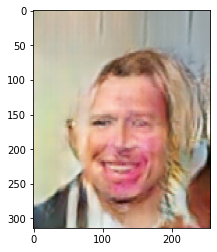

In [64]:
# load the desired Generator checkpoint
# select dedsired epoch
epoch = 5
model_path = f'./binaries/G-DCGAN-{epoch}.pt' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# instantiate model
generator = ConvolutionalGenerativeNet().to(device)
# load model weights from checkpoint
generator.load_state_dict(torch.load(model_path))
# set to validation phase: don't update gradients, no batchnorm in validation phase
generator.eval() 

# store generated images here 
generated_image_path = './images'

# Generate faces (using DCGAN Generator trained on CelebA)
print('Generating celebrity face')
generated_image = generate_from_random_latent_vector(generator)
save_image(generated_image_path, generated_image, display=True)

### 10 Epochs

Generating celebrity face


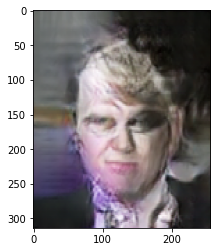

In [65]:
# load the desired Generator checkpoint
# select dedsired epoch
epoch = 10
model_path = f'./binaries/G-DCGAN-{epoch}.pt' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# instantiate model
generator = ConvolutionalGenerativeNet().to(device)
# load model weights from checkpoint
generator.load_state_dict(torch.load(model_path))
# set to validation phase: don't update gradients, no batchnorm in validation phase
generator.eval() 

# store generated images here 
generated_image_path = './images'

# Generate faces (using DCGAN Generator trained on CelebA)
print('Generating celebrity face')
generated_image = generate_from_random_latent_vector(generator)
save_image(generated_image_path, generated_image, display=True)

### 25 Epochs

Generating celebrity face


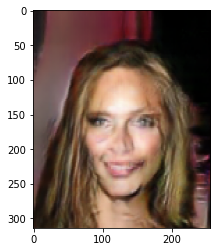

In [67]:
# load the desired Generator checkpoint
# select dedsired epoch
epoch = 25
model_path = f'./binaries/G-DCGAN-{epoch}.pt' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# instantiate model
generator = ConvolutionalGenerativeNet().to(device)
# load model weights from checkpoint
generator.load_state_dict(torch.load(model_path))
# set to validation phase: don't update gradients, no batchnorm in validation phase
generator.eval() 

# store generated images here 
generated_image_path = './images'

# Generate faces (using DCGAN Generator trained on CelebA)
print('Generating celebrity face')
generated_image = generate_from_random_latent_vector(generator)
save_image(generated_image_path, generated_image, display=True)

### 50 Epochs

Generating celebrity face


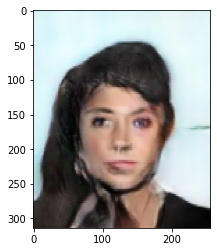

In [77]:
# load the desired Generator checkpoint
# select dedsired epoch
epoch = 50
model_path = f'./binaries/G-DCGAN-{epoch}.pt' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# instantiate model
generator = ConvolutionalGenerativeNet().to(device)
# load model weights from checkpoint
generator.load_state_dict(torch.load(model_path))
# set to validation phase: don't update gradients, no batchnorm in validation phase
generator.eval() 

# store generated images here 
generated_image_path = './images'

# Generate faces (using DCGAN Generator trained on CelebA)
print('Generating celebrity face')
generated_image = generate_from_random_latent_vector(generator)
save_image(generated_image_path, generated_image, display=True)

### 57 Epochs

Generating celebrity face


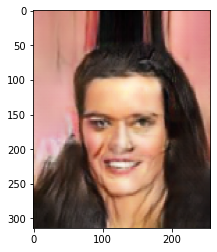

In [102]:
# load the desired Generator checkpoint
# select dedsired epoch
epoch = 57
model_path = f'./binaries/G-DCGAN-{epoch}.pt' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# instantiate model
generator = ConvolutionalGenerativeNet().to(device)
# load model weights from checkpoint
generator.load_state_dict(torch.load(model_path))
# set to validation phase: don't update gradients, no batchnorm in validation phase
generator.eval() 

# store generated images here 
generated_image_path = './images'

# Generate faces (using DCGAN Generator trained on CelebA)
print('Generating celebrity face')
generated_image = generate_from_random_latent_vector(generator)
save_image(generated_image_path, generated_image, display=True)

# Animate the Progress

In [145]:
import imageio

def load_image(img_path, target_shape=None, fps = 60):
    img = cv.imread(img_path)[:, :, ::-1]  # [:, :, ::-1] converts BGR (images saved in opencv format) into RGB

    if target_shape is not None:  # resize section
        if isinstance(target_shape, int) and target_shape != -1:  
            current_height, current_width = img.shape[:2]
            new_width = target_shape
            new_height = int(current_height * (new_width / current_width))
            img = cv.resize(img, (new_width, new_height), interpolation=cv.INTER_CUBIC)
        else:  # set both dimensions to target shape
            img = cv.resize(img, (target_shape[1], target_shape[0]), interpolation=cv.INTER_CUBIC)

    # normalize to [0,1] range after cv.resize pushes it out of that range
    img = img.astype(np.float32)  # convert from uint8 to float32
    img /= 255.0  # get to [0, 1] range
    return img

def create_gif(frames_dir, out_path, downsample=1, img_width=None, fps=60):
    # images saved as .jpg
    frame_paths = [os.path.join(frames_dir, frame_name) for count, frame_name in enumerate(os.listdir(frames_dir)) if count % downsample == 0]

    if img_width is not None: 
        for frame_path in frame_paths:
            img = load_image(frame_path, target_shape=img_width)
            cv.imwrite(frame_path, np.uint8(img[:, :, ::-1] * 255))

    images = [imageio.imread(frame_path) for frame_path in frame_paths]
    imageio.mimwrite(out_path, images, fps)
    print(f'GIF saved {out_path} at {fps} FPS.')

In [ ]:
create_gif('disc_too_smart', 'disc_too_smart.gif', downsample=1, fps = 120)

In [135]:
# get the gif to my gdrive so I can show it off on github
!cp '59epochs.gif' '/content/drive/My Drive/DL/DCGAN'

# Lessons Learned: How to Stabilize and Optimize a GAN

- Use Dropout ONLY ON DISCRIMINATOR, and not on final layer of disciriminator. 
- Activation function: In terms of performance for this model, I found LeakyReLU > SELU > ReLU.
- Use Gaussian Instance Noise ONLY ON DISCRIMINATOR.
- Gaussian Instance Noise/Pixel Wise Normalization is not helpful to discriminator when using SpectralNorm + BatchNorm.
- Optimizer: Adam is better than SGD for discriminator, although SGD has been used to slow down the discriminator - but SGD is not necessary with proper discriminator normalization.
- Slowing down discriminator with learning rates and different learning schedule is dubious and rarely works.
- One-sided label smoothing: set discriminator labels for real images from 1 -> 0.9 to make the discriminator's job harder only
- Popular GANHacks GitHub page incorrectly says to smooth both real and fake labels (1->0.9, 0->0.1).
- SpectralNorm is a powerful normalization technique and can be used together with BatchNorm.
- SpectralNorm can replace the normalization power of SELU. 
- batch size: huge batch is much faster to train (1024), but smaller batches train MUCH better GANs.
- batch in radford et al (128) works well; smaller batches (64) work even better but slower to train.
- Use BCELossWithLogits and no sigmoid activation on final discriminator layer: More Stable than BCELoss() due to log of exponential dynamics.
- SELU from HDCGAN paper (SNN): Performed as well as LeakyReLU for this model. SpecNorm+BatchNorm probably means weights are already regularized enough that SELU behaves like LeakyReLU. 
- SELU is self normalizing but I found better to have explicit normalization such as SpecNorm and BatchNorm.
- Adding Gaussian Instance Noise makes discriminator much less sensitive to hyperparams.

# References
- Radford et al, 2015 https://arxiv.org/abs/1511.06434
- Goodfellow et al, 2014 https://arxiv.org/abs/1406.2661
- SELU + BatchNorm: https://arxiv.org/pdf/1711.06491.pdf
- Low Batch Sizes for DCGAN: https://arxiv.org/pdf/1711.06491.pdf
- HDCGAN: https://arxiv.org/pdf/1711.06491.pdf
- Normalized DCGAN better than WGAN: https://arxiv.org/pdf/1801.04406.pdf
- WGAN: https://arxiv.org/abs/1701.07875 
- minibatchstdev, pixelwisenorm:https://arxiv.org/abs/1710.10196: 
- specnorm: https://openreview.net/pdf?id=B1QRgziT-
- gradient flow function: https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10
- celeba: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
- GanHacks: https://github.com/soumith/ganhacks/blob/master/README.md
- GAN Stabilization: https://arxiv.org/abs/1701.04862
- Instance Noise: https://arxiv.org/abs/1906.04612
- Spectral Norm for GANs: https://sthalles.github.io/advanced_gans/
- Improved GANs: https://arxiv.org/pdf/1606.03498.pdf
- Guide to CNN math: https://arxiv.org/pdf/1603.07285.pdf
- Torch DCGAN tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
